https://betanalpha.github.io/assets/case_studies/bayes_sparse_regression.html

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
from theano import tensor as tt

import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

## Data generation

In [2]:
M, N, alpha0, sigma0, sig_prob0 = 200, 100, 3., 1., .05
X = np.random.randn(N, M)
beta0 = np.random.randn(M, 1)*.25
index = np.random.binomial(1, sig_prob0, M)
beta0[index == 1, :] = np.random.randn(
    sum(index), 1) + 10*np.random.choice([-1, 1], sum(index))[:, None]
y = np.random.normal(np.dot(X, beta0)+alpha0, sigma0)

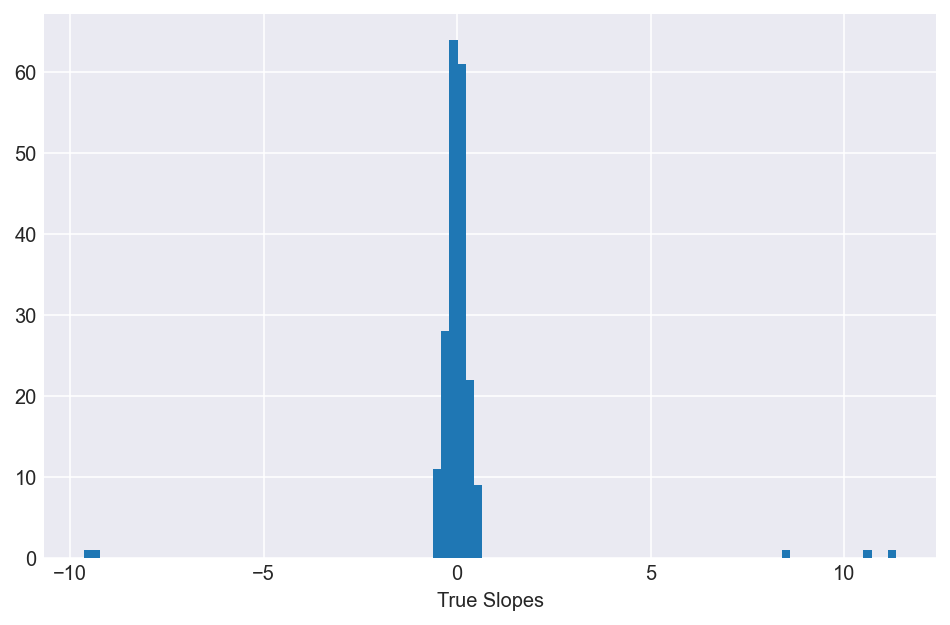

In [3]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(beta0, 100)
ax.set_xlabel('True Slopes');

## plotting

In [4]:
def plot_slope(trace, priorname):
    beta_post = np.squeeze(trace[750:]['beta']).T
    
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(np.arange(M), beta_post, alpha=.01, color='grey', linestyle='-')
    ax.step(np.arange(M), beta_post.mean(axis=1), color='r')
    ax.step(beta0, 'k', alpha=.5)
    ax.vlines(np.where(index==1)[0]-.5,
              -15, 15, linestyle='--', alpha=.5)
    ax.set_title(priorname)
    ax.set_xlabel('Slope Index')
    ax.set_ylabel('Slope Posterior')
    return ax

In [5]:
def plot_slope_diff(trace, priorname):
    beta_post = np.squeeze(trace[750:]['beta']).T
    
    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.step(np.arange(M), beta_post-beta0, alpha=.01, color='grey', linestyle='-')
    ax.step(np.arange(M), beta_post.mean(axis=1, keepdims=True)-beta0, color='r')
    ax.hlines(0, 0, M, 'k', alpha=.5)
    ax.vlines(np.where(index==1)[0]-.5,
              -15, 15, linestyle='--', alpha=.5)
    ax.set_title(priorname)
    ax.set_xlabel('Slope Index')
    ax.set_ylabel('Slope Posterior')
    return ax

In [6]:
def plot_posterior(trace, priorname):
    axes = pm.plot_posterior(trace, 
                      var_names=['alpha', 'sigma'], 
                      ref_val=[alpha0, sigma0],
                      color='#87ceeb');
    axes[0].set_title(priorname)
    axes[0].set_xlabel('alpha')
    axes[1].set_title(priorname)
    axes[1].set_xlabel('sigma')
    return axes

## Uniform Prior

In [7]:
with pm.Model() as unif:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Flat('beta', shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace0 = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1225 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6905419572456248, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_

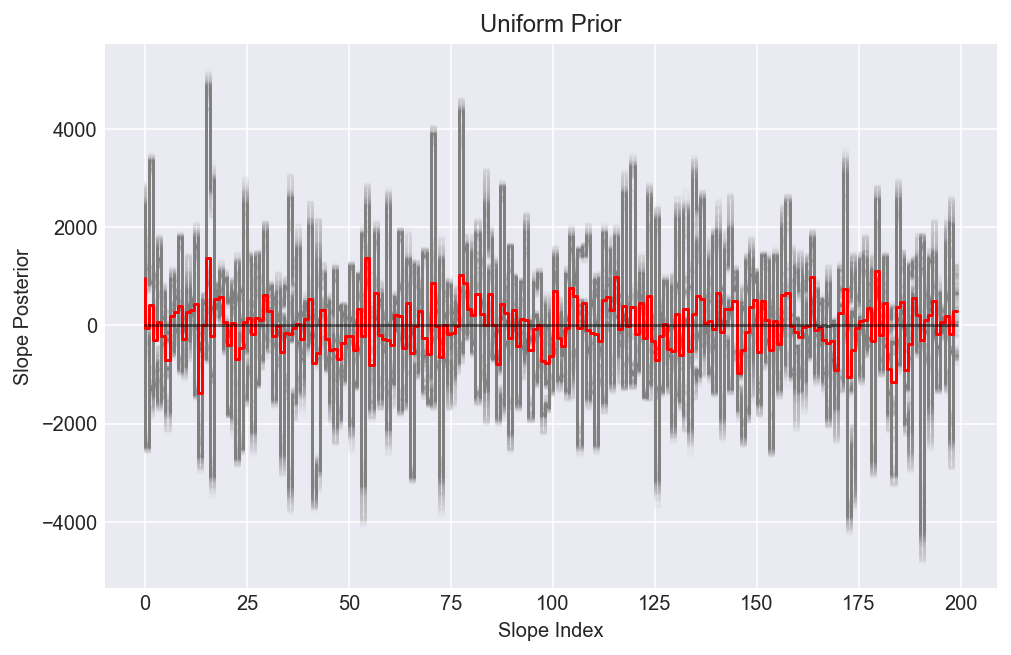

In [8]:
plot_slope(trace0, 'Uniform Prior');

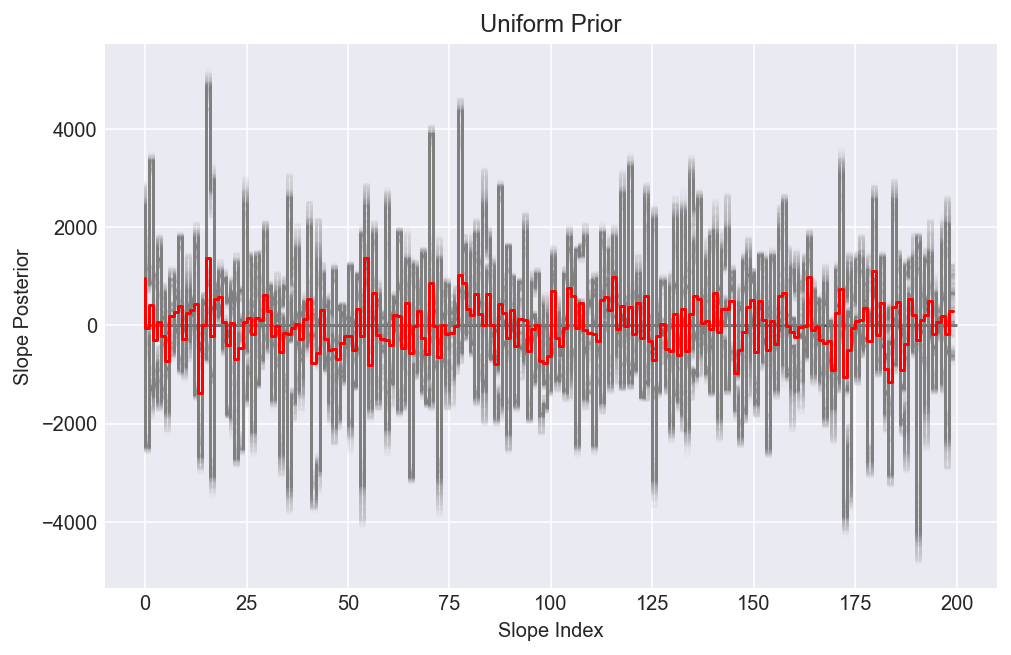

In [9]:
plot_slope_diff(trace0, 'Uniform Prior');

/home/junpenglao/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


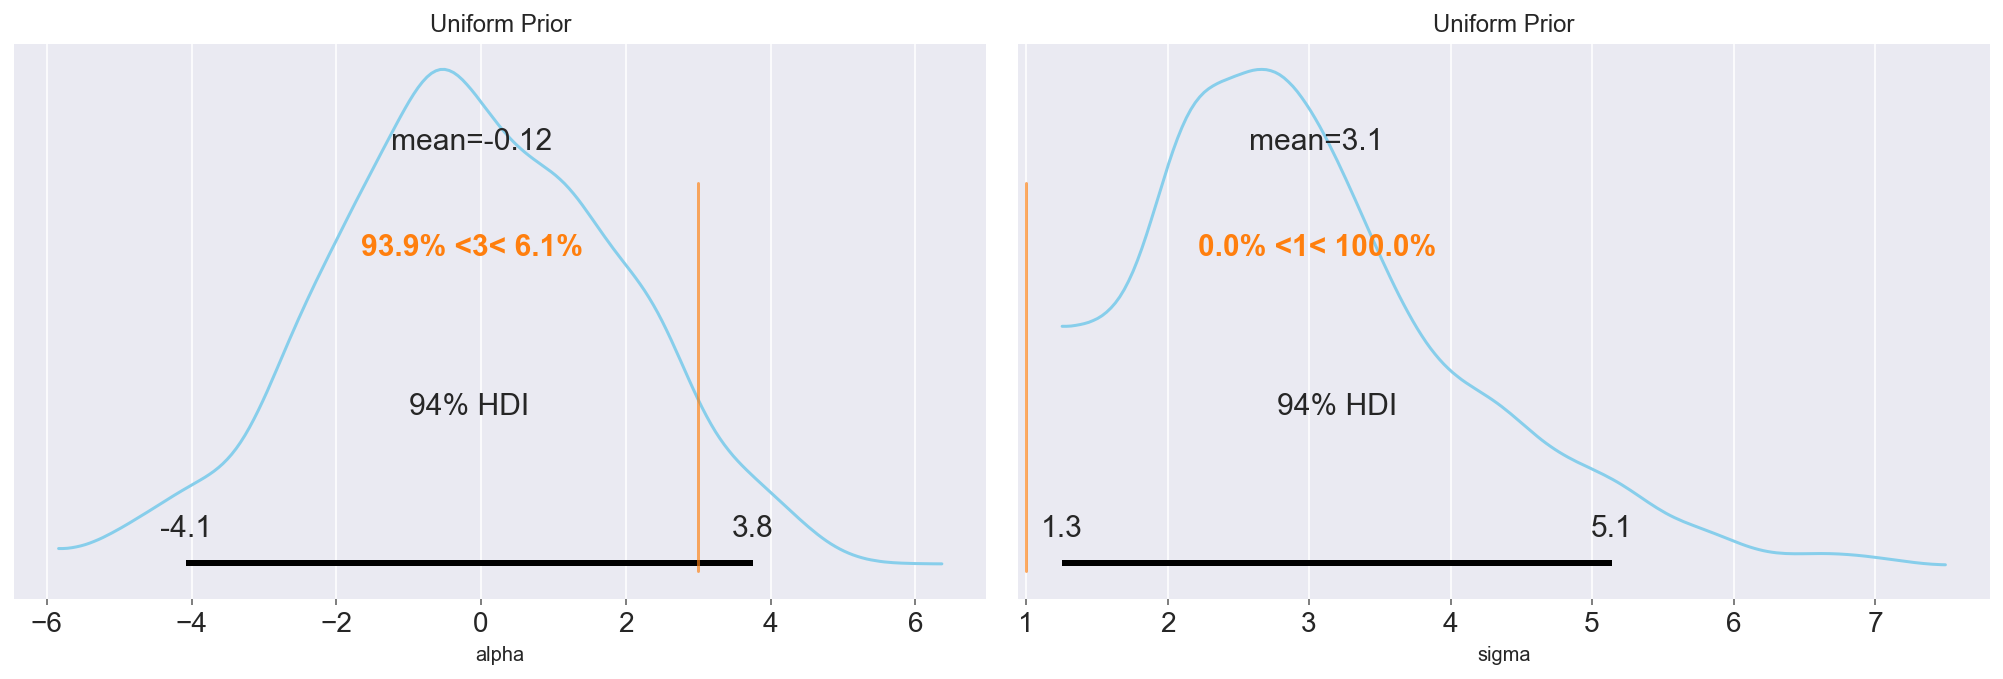

In [10]:
plot_posterior(trace0, 'Uniform Prior');

## Wide Weakly Informative Prior

In [11]:
with pm.Model() as wide:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Normal('beta', mu=0., sd=10., shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace1 = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 938 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7198942396015643, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9188407905033494, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6727865690717285, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


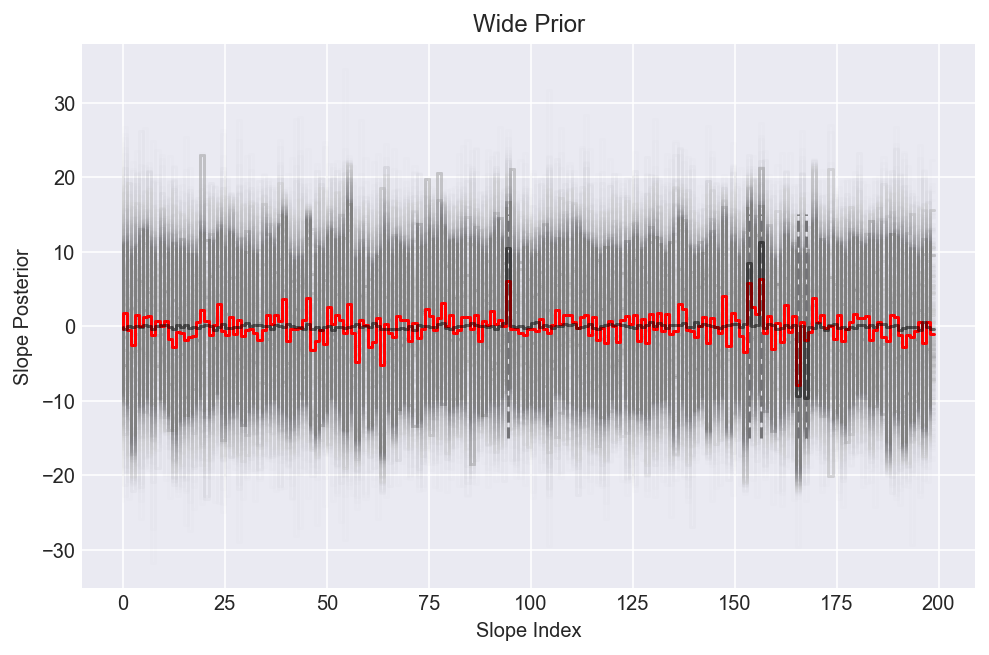

In [12]:
plot_slope(trace1, 'Wide Prior');

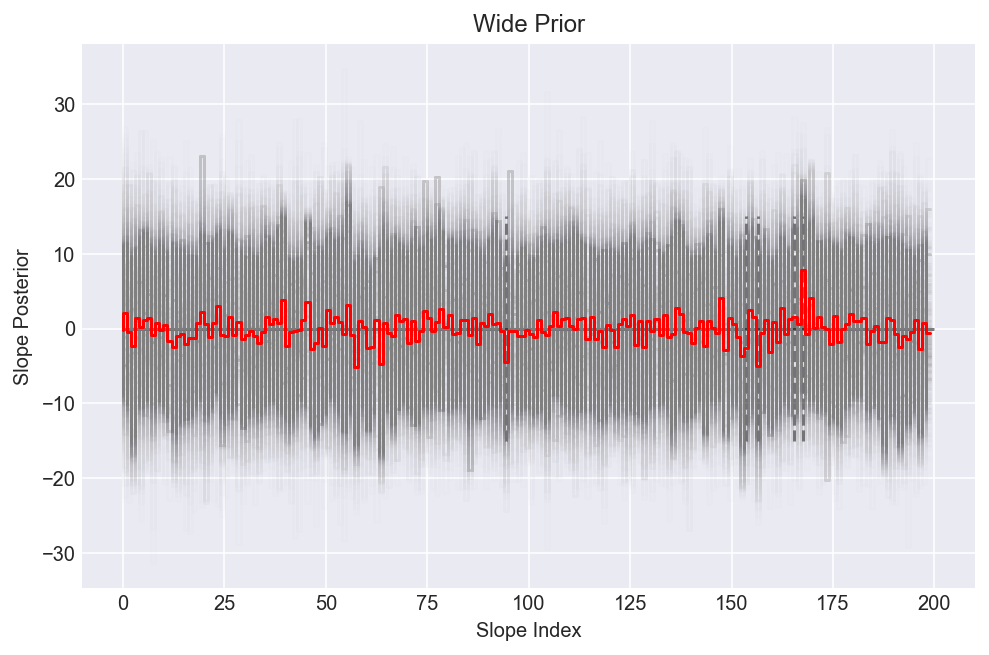

In [13]:
plot_slope_diff(trace1, 'Wide Prior');

/home/junpenglao/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


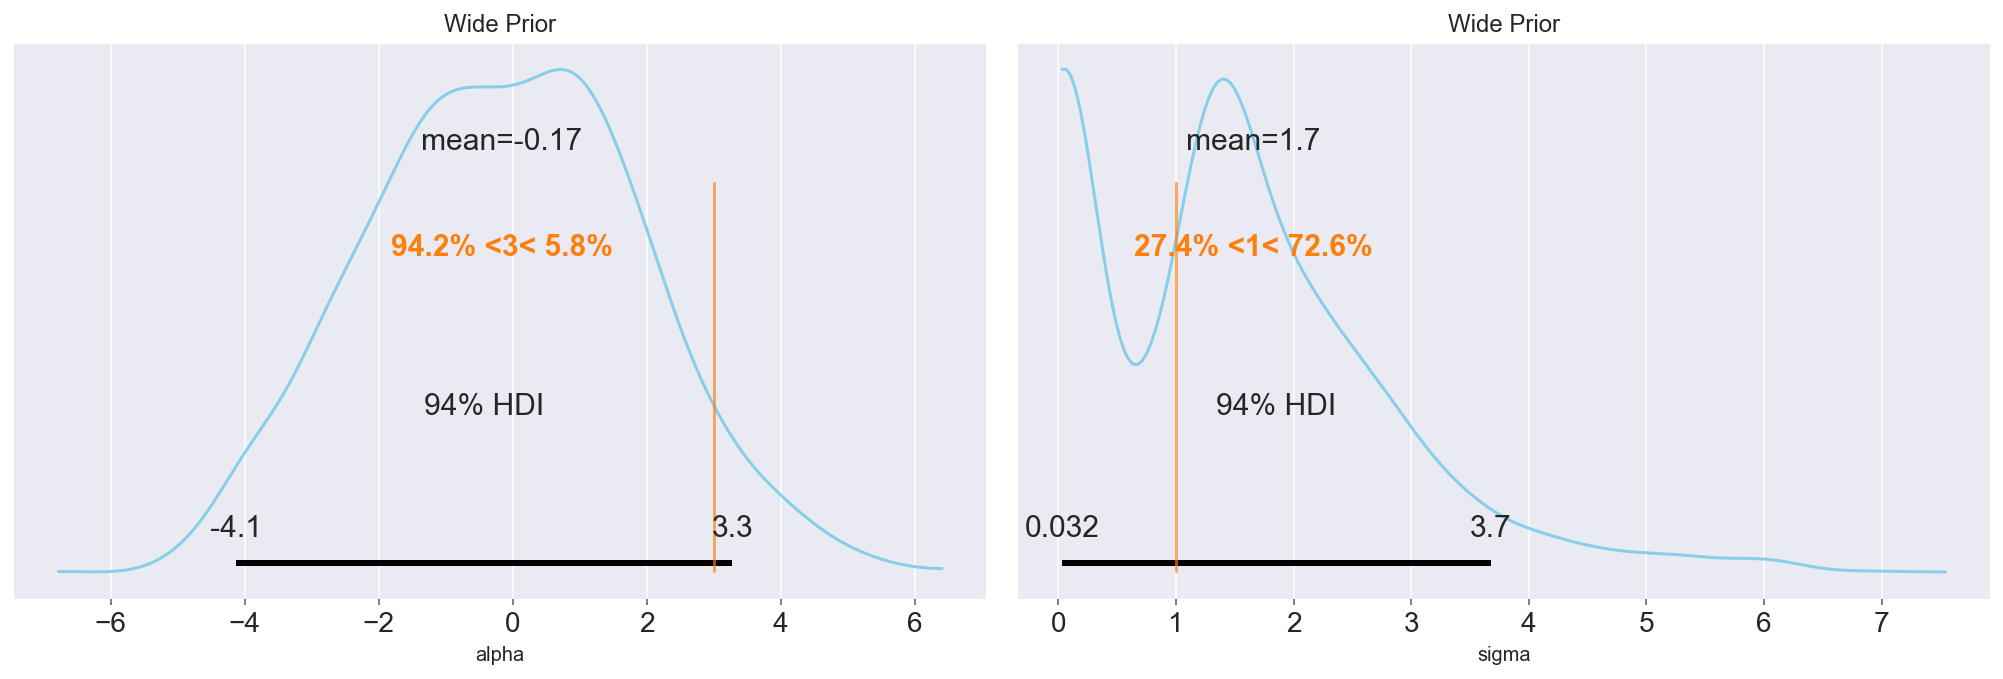

In [14]:
plot_posterior(trace1, 'Wide Prior');

## Narrow Weakly Informative Prior

In [15]:
with pm.Model() as narrow:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Normal('beta', mu=0., sd=1., shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace2 = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.


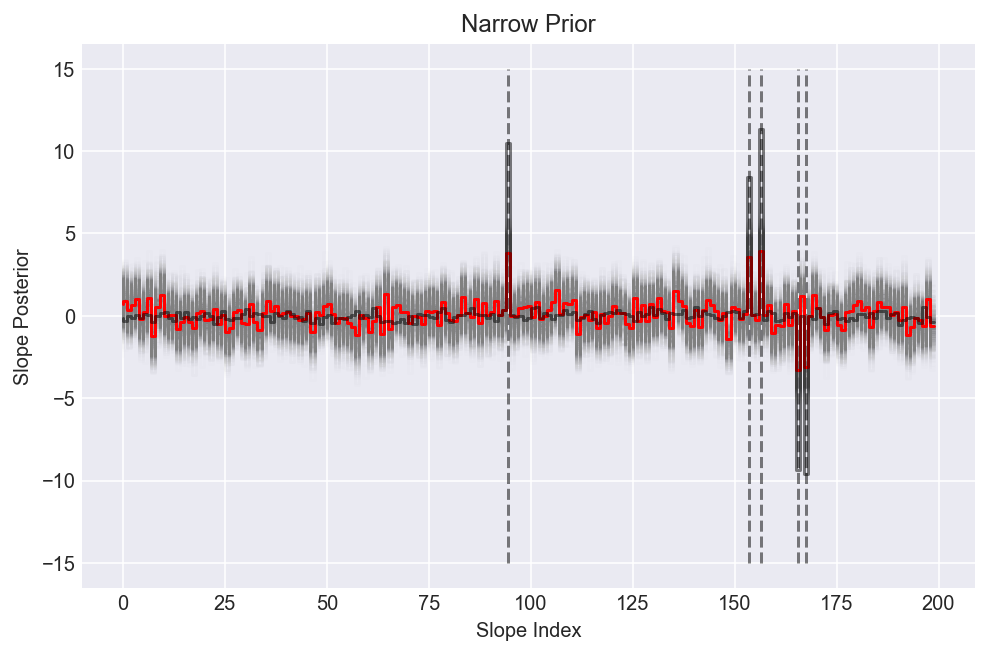

In [16]:
plot_slope(trace2, 'Narrow Prior');

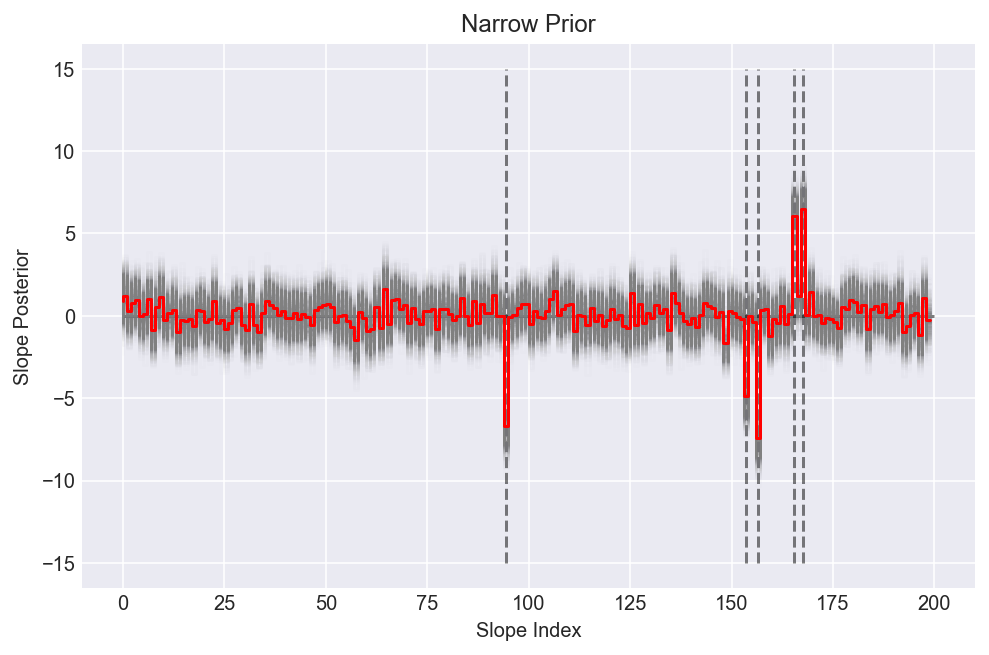

In [17]:
plot_slope_diff(trace2, 'Narrow Prior');

/home/junpenglao/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


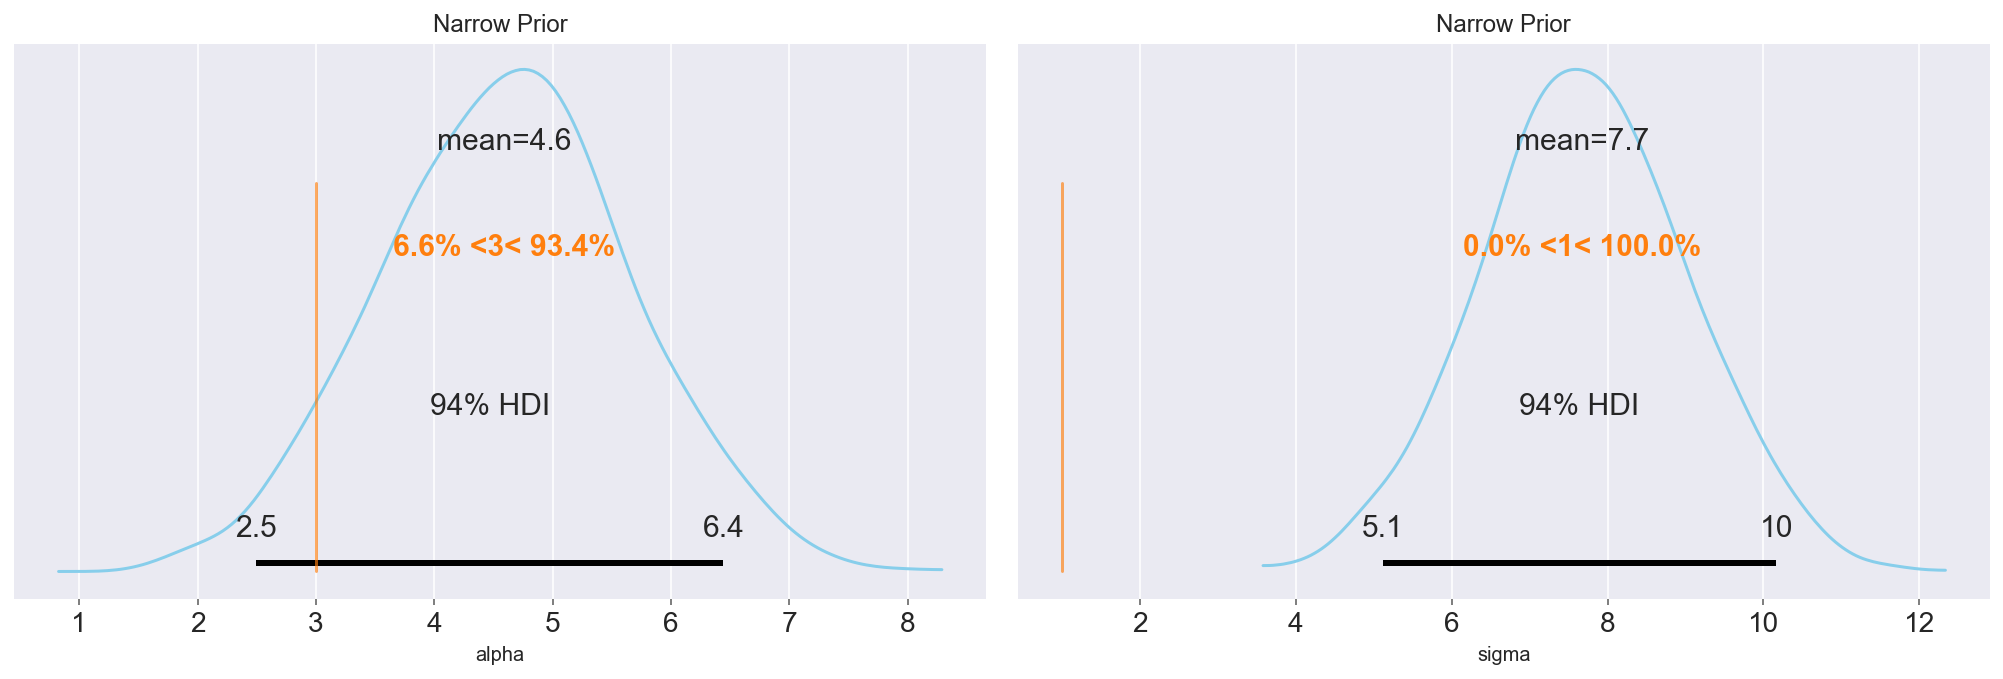

In [18]:
plot_posterior(trace2, 'Narrow Prior');

## Laplace Prior

In [19]:
with pm.Model() as laplace:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)
    beta = pm.Laplace('beta', mu=0., b=1., shape=(M, 1))
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace3 = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 419 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6803642565628916, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


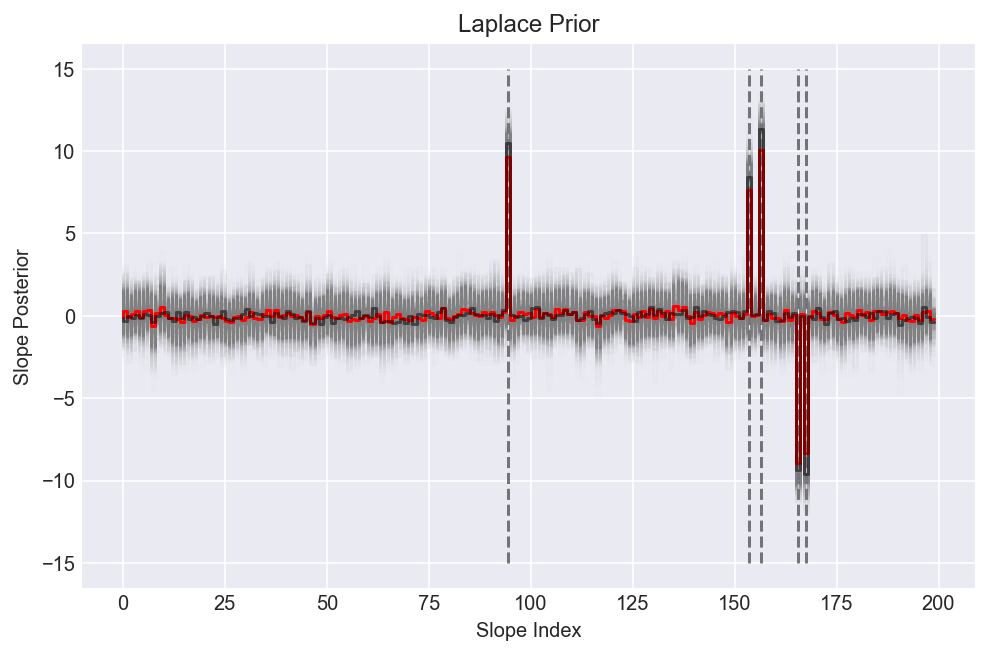

In [20]:
plot_slope(trace3, 'Laplace Prior');

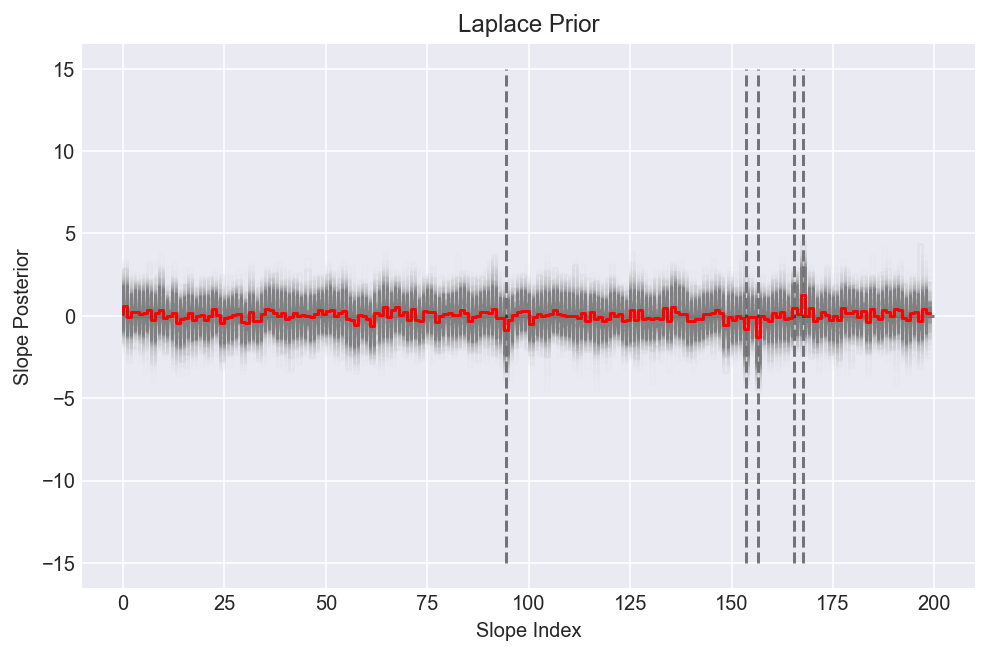

In [21]:
plot_slope_diff(trace3, 'Laplace Prior');

/home/junpenglao/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


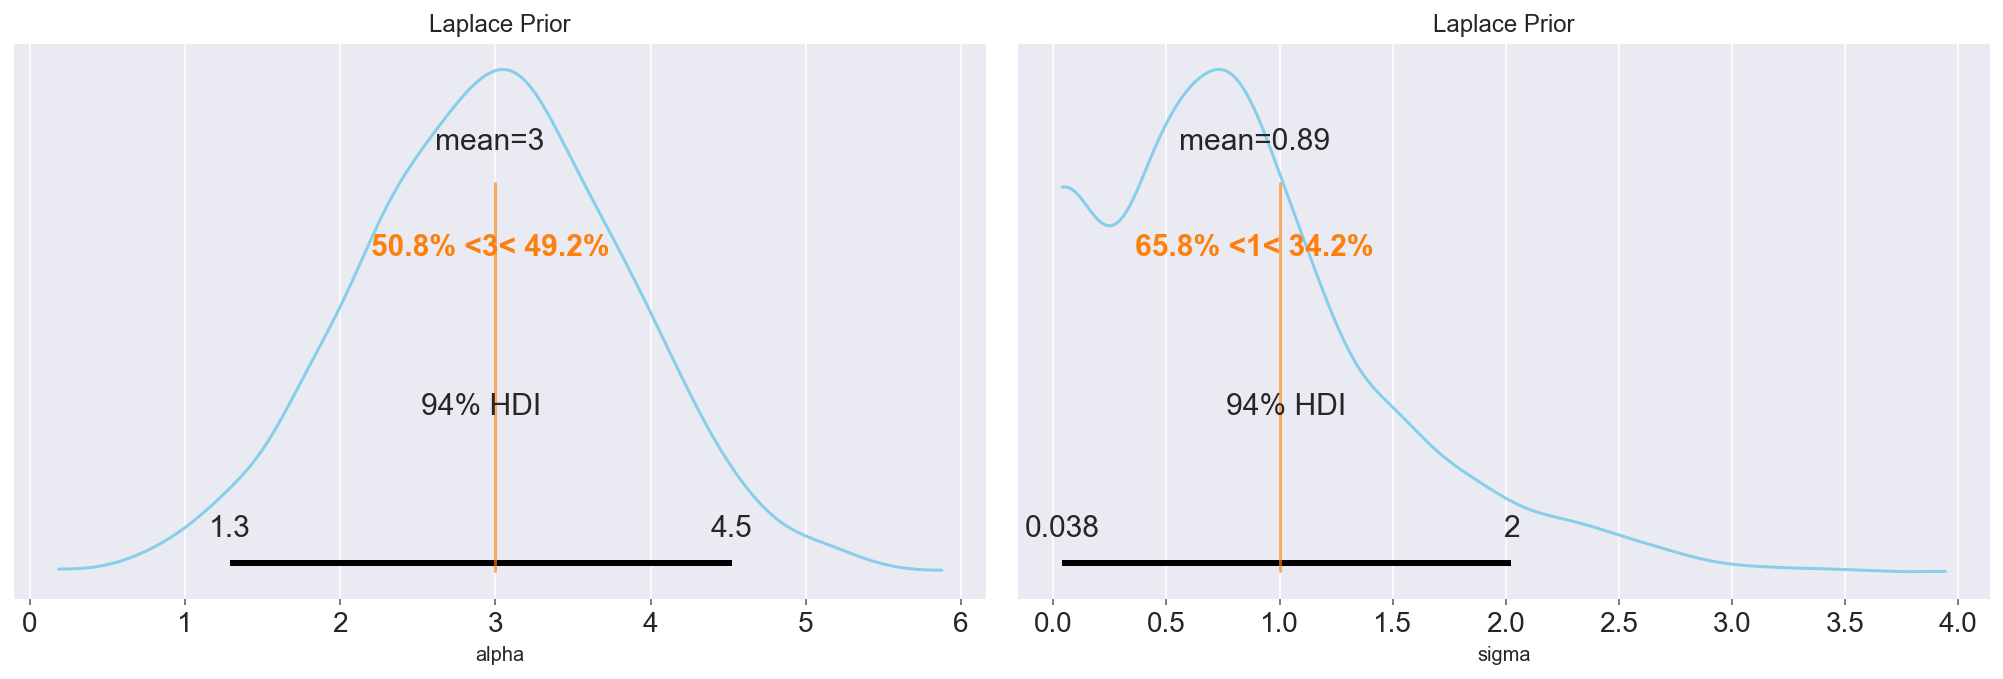

In [22]:
plot_posterior(trace3, 'Laplace Prior');

## The Horseshoe

In [23]:
with pm.Model() as horseshoe:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)

    beta_tilde = pm.Normal('beta_tilde', mu=0., sd=1., shape=(M, 1))
    lambda_ = pm.HalfCauchy('lambda', beta=1., shape=(M, 1))
    tau_tilde = pm.HalfCauchy('tau_tilde', beta=1.)
    beta = pm.Deterministic('beta', beta_tilde * lambda_ * sigma * tau_tilde)
    
    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace4 = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_tilde, lambda, beta_tilde, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 313 seconds.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
There were 255 divergences after tuning. Increase `target_accept` or reparameterize.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.16284717988301456, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


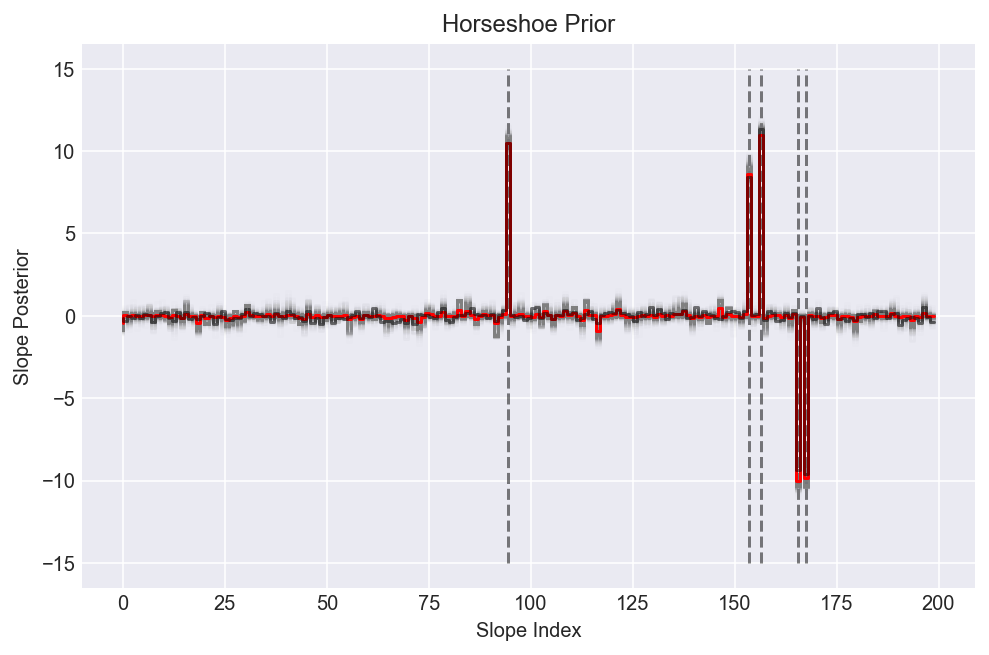

In [24]:
plot_slope(trace4, 'Horseshoe Prior');

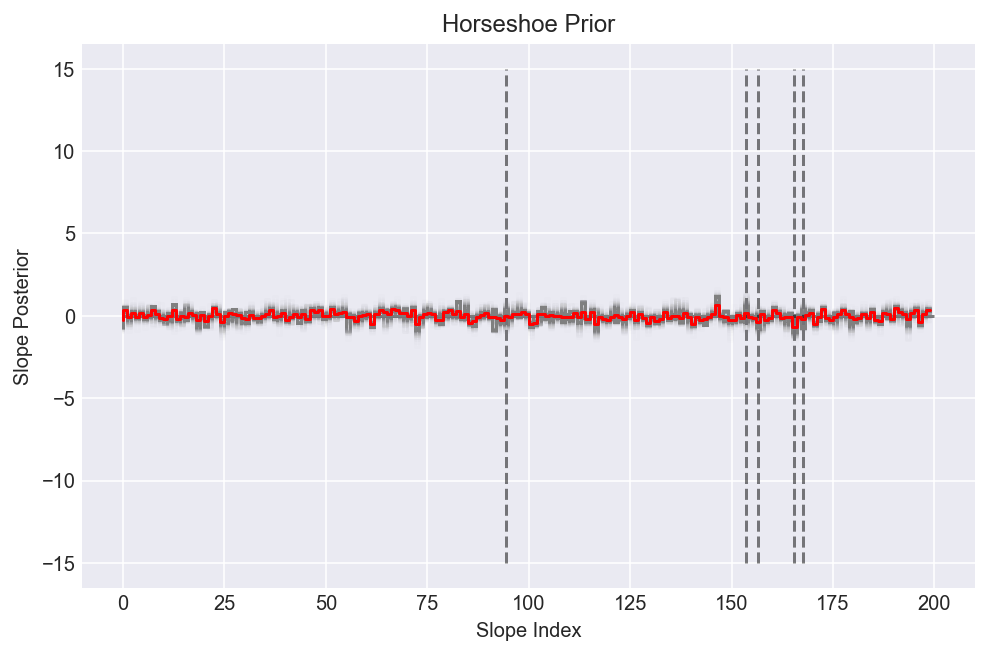

In [25]:
plot_slope_diff(trace4, 'Horseshoe Prior');

/home/junpenglao/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


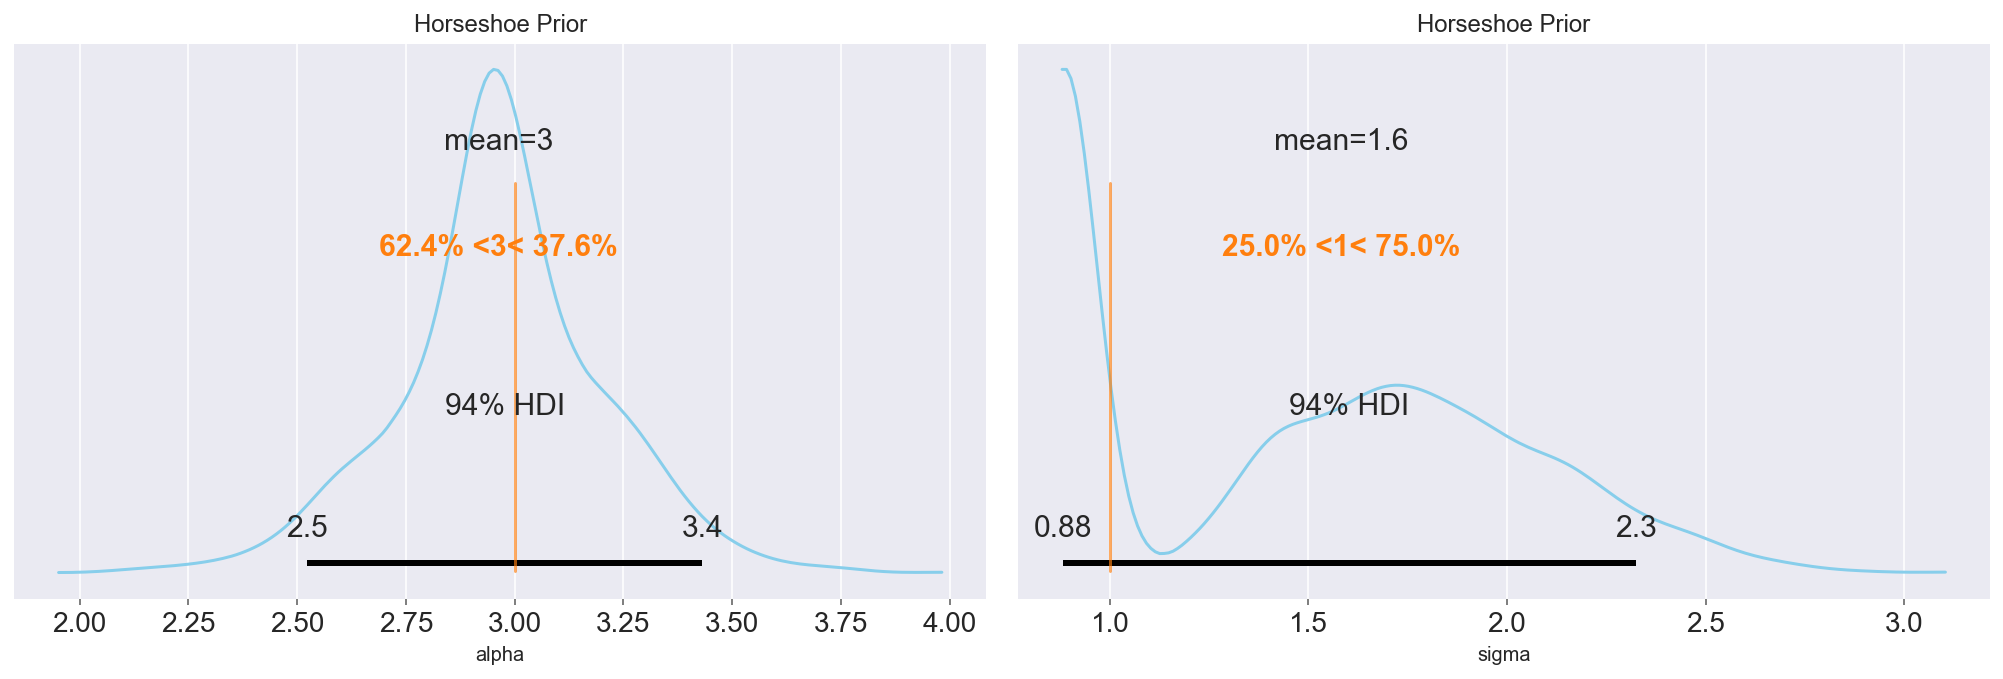

In [26]:
plot_posterior(trace4, 'Horseshoe Prior');

## The Finnish Horseshoe

In [27]:
m0 = 10            # Expected number of large slopes
slab_scale = 3,    # Scale for large slopes
slab_scale2 = np.square(slab_scale)
slab_df = 25.      # Effective degrees of freedom for large slopes
half_slab_df = 0.5 * slab_df

In [28]:
with pm.Model() as finnish_horseshoe:
    alpha = pm.Normal('alpha', mu=0., sd=2.)
    sigma = pm.HalfNormal('sigma', sd=2.)

    beta_tilde = pm.Normal('beta_tilde', mu=0., sd=1., shape=(M, 1))
    lambda_ = pm.HalfCauchy('lambda', beta=1., shape=(M, 1))
    tau_tilde = pm.HalfCauchy('tau_tilde', beta=1.)
    c2_tilde = pm.InverseGamma(
        'c2_tilde', alpha=half_slab_df, beta=half_slab_df)

    tau0 = (m0 / (M - m0)) * (sigma / np.sqrt(1.0 * N))
    tau = tau0 * tau_tilde  # tau ~ cauchy(0, tau0)
    # c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
    # Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
    c2 = slab_scale2 * c2_tilde

    lambda_tilde = tt.sqrt(c2 * tt.square(lambda_) /
                           (c2 + tt.square(tau) * tt.square(lambda_)))
    # beta ~ normal(0, tau * lambda_tilde)
    beta = pm.Deterministic('beta', tau * lambda_tilde * beta_tilde)

    pm.Normal('obs', tt.dot(X, beta)+alpha, sigma, observed=y)
    trace5 = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2_tilde, tau_tilde, lambda, beta_tilde, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


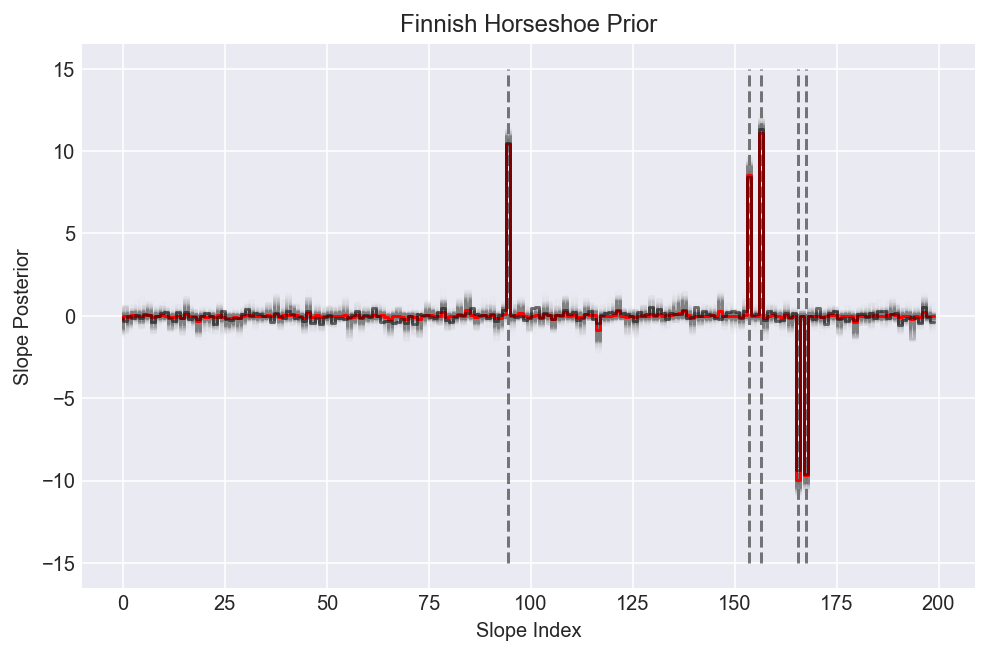

In [29]:
plot_slope(trace5, 'Finnish Horseshoe Prior');

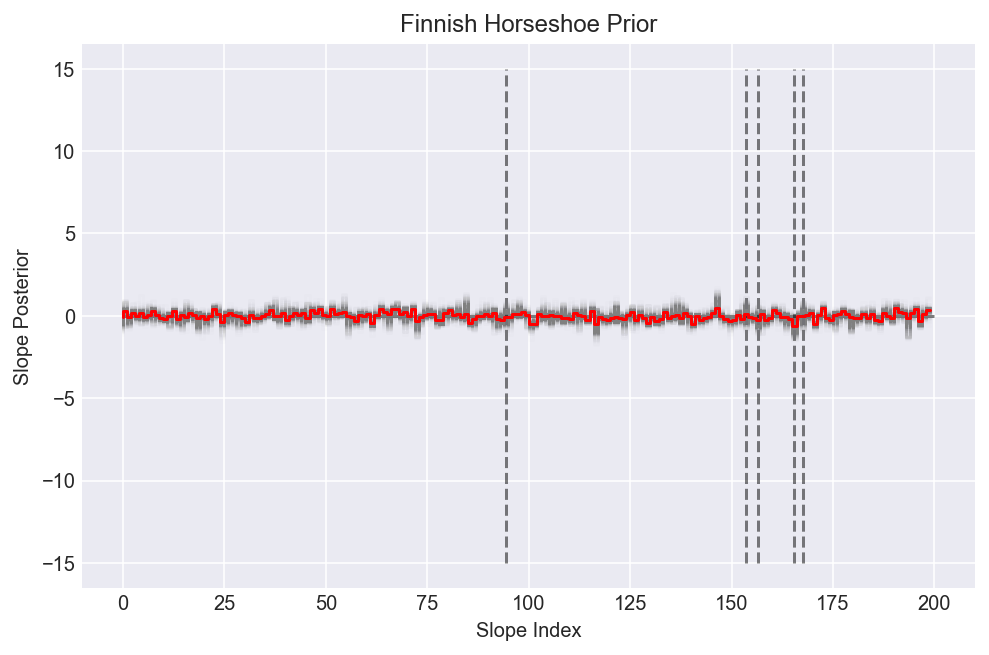

In [30]:
plot_slope_diff(trace5, 'Finnish Horseshoe Prior');

/home/junpenglao/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


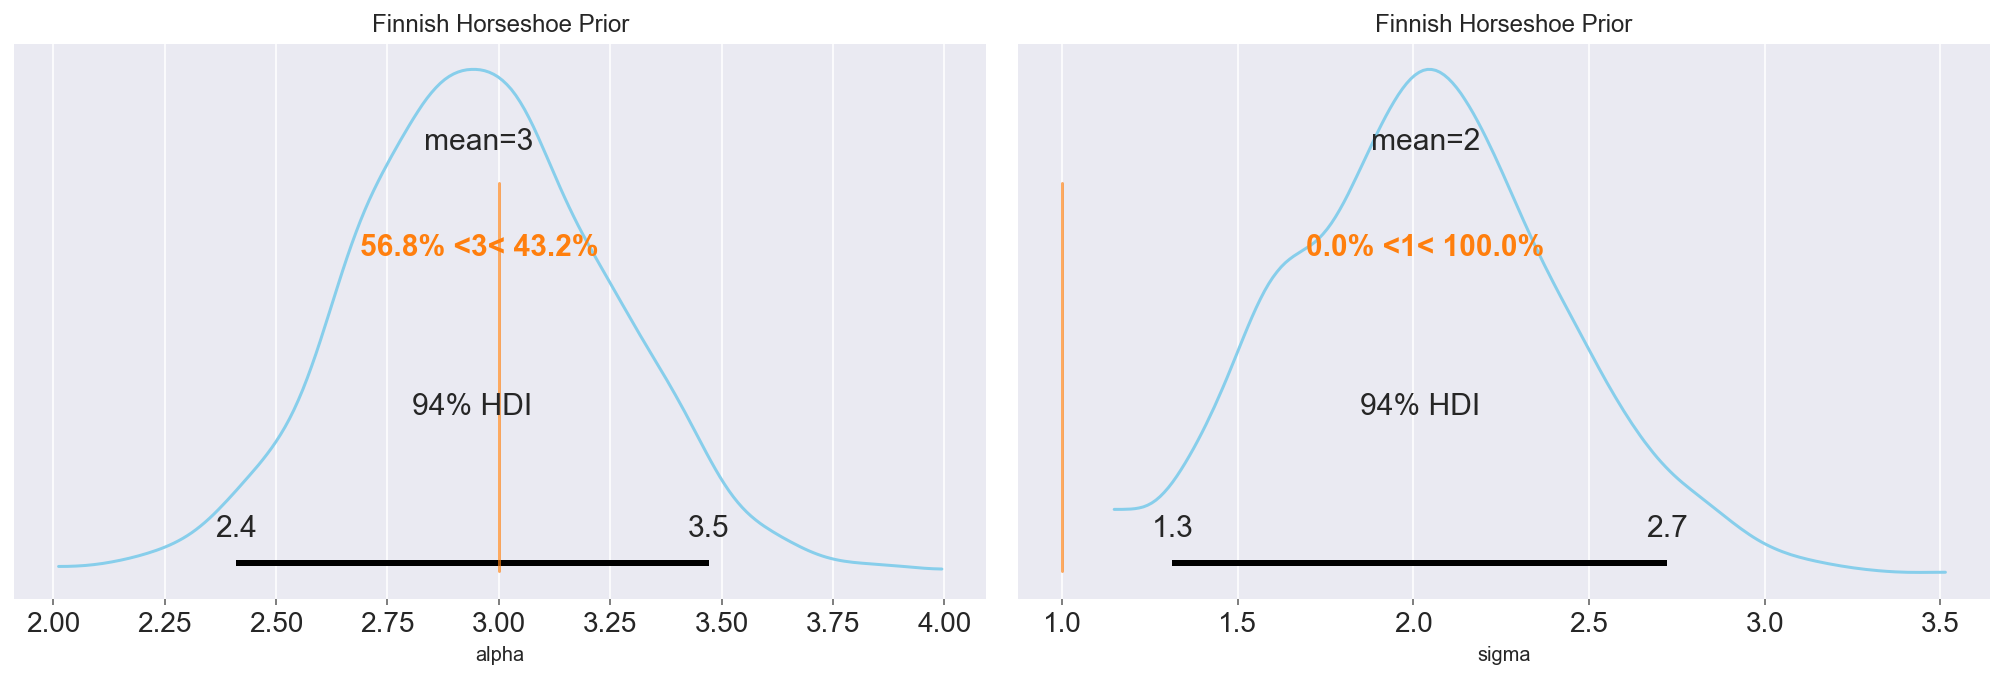

In [31]:
plot_posterior(trace5, 'Finnish Horseshoe Prior');

## Comparison

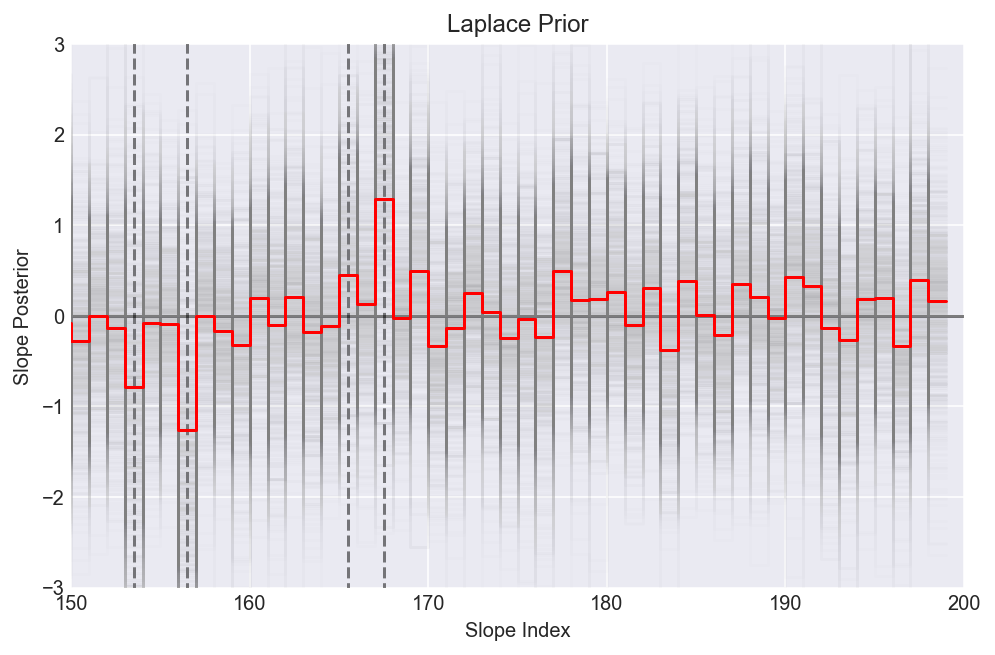

In [32]:
ax = plot_slope_diff(trace3, 'Laplace Prior')
ax.set_xlim(150, 200)
ax.set_ylim(-3, 3);

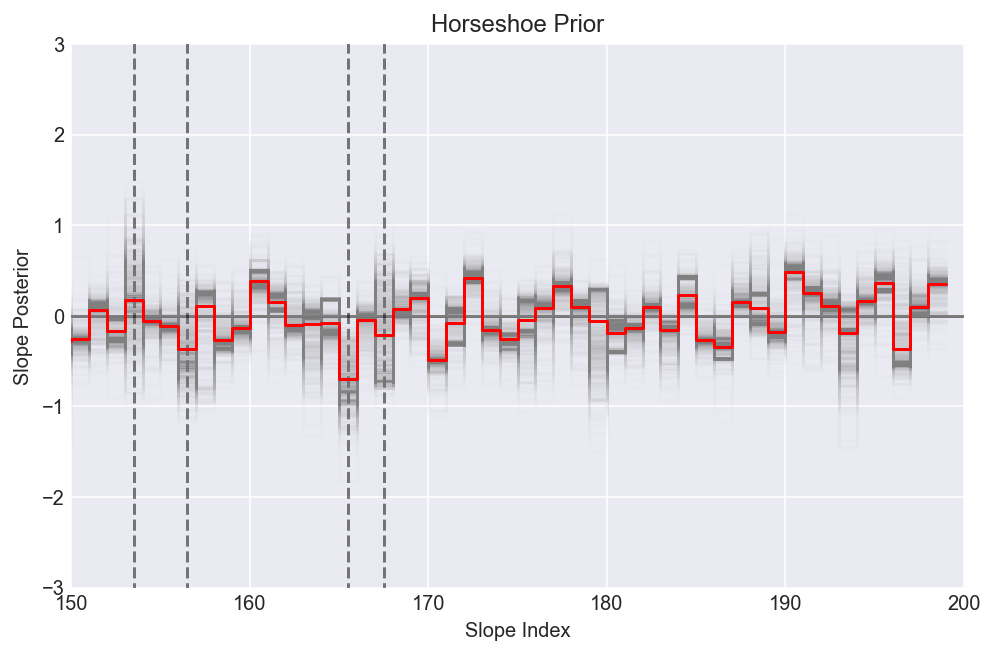

In [33]:
ax = plot_slope_diff(trace4, 'Horseshoe Prior')
ax.set_xlim(150, 200)
ax.set_ylim(-3, 3);

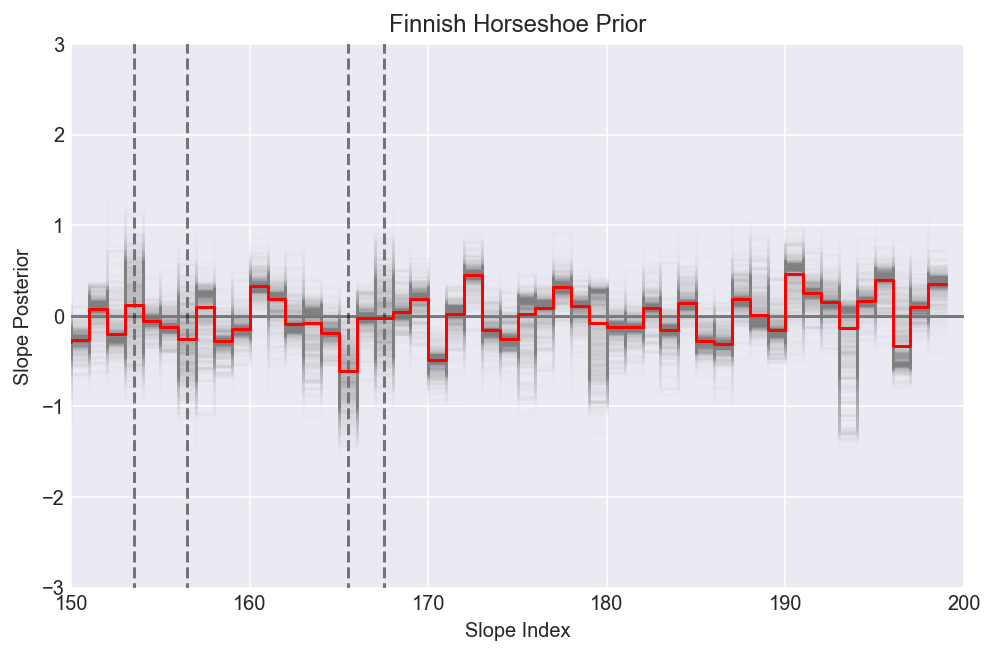

In [34]:
ax = plot_slope_diff(trace5, 'Finnish Horseshoe Prior')
ax.set_xlim(150, 200)
ax.set_ylim(-3, 3);